In [231]:
import importlib
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

import utility_v1
import propagators_v1
import energy_landscapes_v1

import parallel_simulations_v1
import weighted_ensemble_v1
import metadynamics_v1

import visualization_v1

#methods for fast print debugging #<---- these probably belong in utility_v1.py
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)

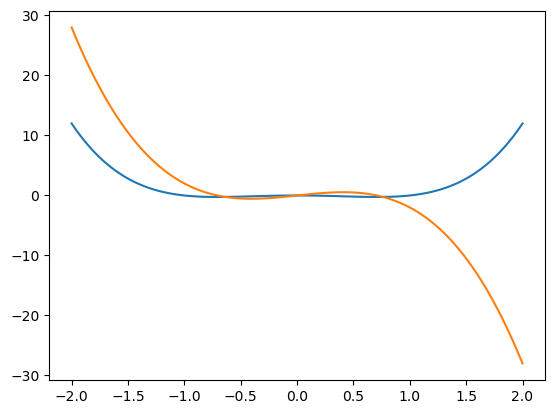

In [ ]:
kT = 1
dt = 0.001

importlib.reload(energy_landscapes_v1)

system1 = energy_landscapes_v1.unit_double_well()
system1.plot_quantity(system1.potential)
system1.plot_quantity(system1.F)
plt.show()

eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
WE round 0
WE round 1
WE round 2
WE round 3
WE round 4
WE round 5
WE round 6
WE round 7
WE round 8
WE round 9
eigenvector converged to within 10^-12 after 0 rounds
WE round 0
WE round 1
WE round 2
WE round 3
WE round 4
WE round 5
WE round 6
WE round 7
WE round 8
WE round 9
eigenvector converged to within 10^-12 after 1 rounds
WE round 0
WE round 1
WE round 2
WE round 3
WE round 4
WE round 5
WE round 6
WE round 7
WE round 8
WE round 9
eigenvector converged 

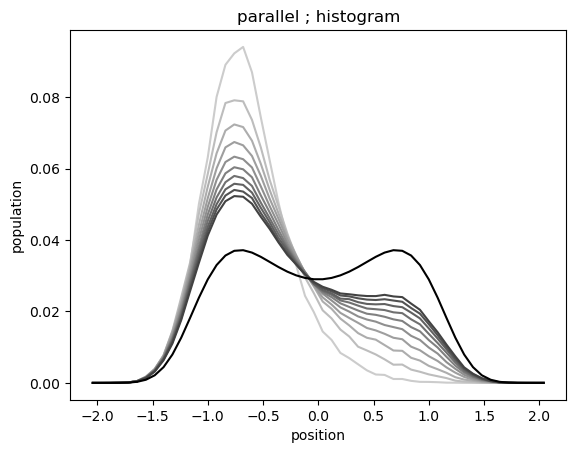

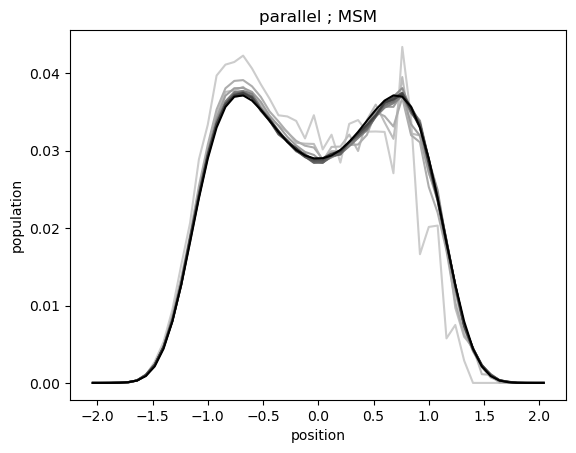

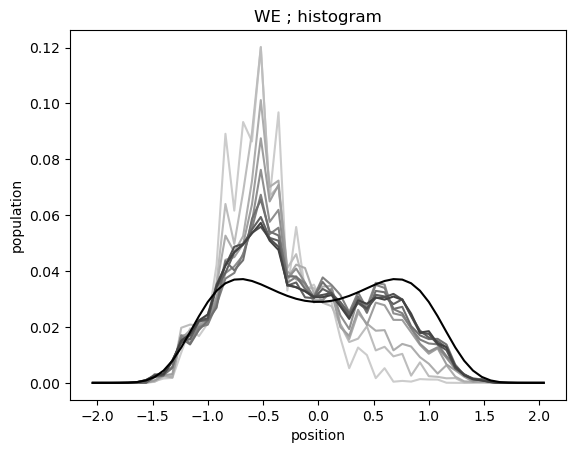

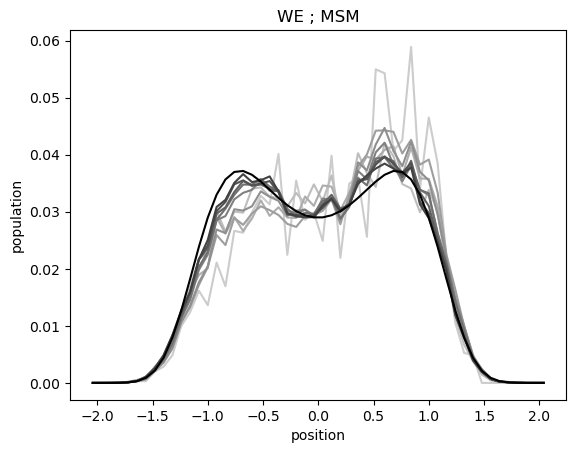

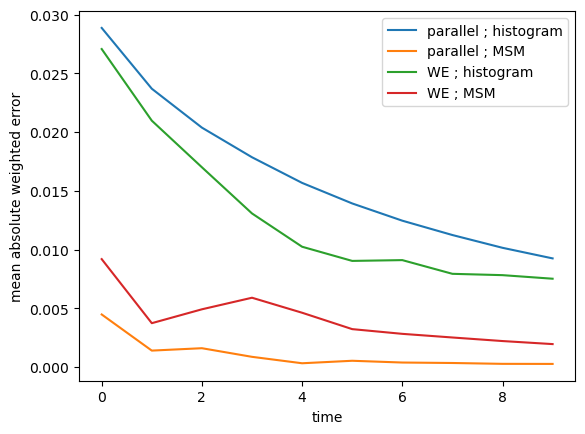

In [ ]:
importlib.reload(utility_v1)
importlib.reload(propagators_v1)
importlib.reload(energy_landscapes_v1)

importlib.reload(parallel_simulations_v1)
importlib.reload(weighted_ensemble_v1)
importlib.reload(metadynamics_v1)

importlib.reload(visualization_v1)

#hyperparameters for estimating convergence
n_timepoints = 10
n_bootstrap = 3

#binning parameters
n_analysis_bins = 50
#save frequency

#simulation time limits (integration steps)
aggregate_simulation_limit = 10000000
#frame_save_limit = 100000
molecular_time_limit = 2000

#move the number of WE rounds out here; number of data points should be held constant across methods because it reflects lab storage capacity
we_rounds_per_timepoint = 10
save_period = int(round(molecular_time_limit/(we_rounds_per_timepoint*n_timepoints))) #in steps

#define bins and calculate the true populations thereof
binbounds, bincenters, step = system1.analysis_bins_1d(n_analysis_bins)
true_populations, true_energies = system1.normalized_pops_energies(kT, bincenters)


observables_parallel = parallel_simulations_v1.sampler_parallel_hist(system1, aggregate_simulation_limit, molecular_time_limit, save_period, n_timepoints, kT, dt, binbounds, bincenters)
observables_we = weighted_ensemble_v1.sampler_we_hist(system1, aggregate_simulation_limit, molecular_time_limit, n_timepoints, we_rounds_per_timepoint, kT, dt, binbounds)

landscape_estimates = [[observables_parallel[0], observables_parallel[1], "parallel ; histogram"], 
                       [observables_parallel[2], observables_parallel[3], "parallel ; MSM"], 
                       [observables_we[0], observables_we[1], "WE ; histogram"], 
                       [observables_we[2], observables_we[3], "WE ; MSM"]]

#----------------------------------------------------PLOT RESULTS----------------------------------------------------

#landscape estimates
for le in landscape_estimates:
    visualization_v1.plot_landscape_estimate(bincenters, le[1], true_populations, le[2])


#convergence over time
for le in landscape_estimates:
    plt.plot(le[0])

plt.legend([le[2] for le in landscape_estimates])
plt.xlabel("time")
plt.ylabel("mean absolute weighted error")
plt.show()


In [ ]:

#---------------------------------------------------------------------------------------------------------------------------

# #bin boundaries along each dimension
# binbounds = [np.linspace(system1.standard_analysis_range[0][0], system1.standard_analysis_range[1][0], 14+1),
#              np.linspace(system1.standard_analysis_range[0][1], system1.standard_analysis_range[1][1], 6+1)]

# #get true populations
# state_bins = msm_trj_analysis.bin_to_voxels_msmstates(binbounds, system1.x)
# state_pops = msm_trj_analysis.state_to_bin_populations(state_bins, system1.p)

# #run sampler
# est_state_pop_convergence_we, maew_convergence_we = weighted_ensemble_4.sampler_we_hist(system1, int(nsteps/10), n_timepoints, kT, dt, binbounds)
# est_state_pop_convergence_parallel, maew_convergence_parallel = msm_trj_long_simulation.sampler_parallel_hist(system1, n_parallel, nsteps, save_period, n_timepoints, kT, dt, binbounds)

# #plot results
# for espc in est_state_pop_convergence_parallel:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# #plot results
# for espc in est_state_pop_convergence_we:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# plt.plot(maew_convergence_parallel)
# plt.plot(maew_convergence_we)
# plt.show()